In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
import warnings

from sklearn.linear_model import HuberRegressor, TheilSenRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA

warnings.filterwarnings('ignore')
sbn.set(style='white')

In [2]:
train_data = pd.read_csv('dataset/train.csv')
test_data = pd.read_csv('dataset/test.csv')

In [3]:
# cols = ['SMA', 'EMA', 'WMA', 'DEMA', 'TEMA', 'TRIMA', 'KAMA', 'MAMA', 'FAMA', 'Price', 'Company ', 'ID', 'Date', 'QUADRATURE', 'T3', 'Real Lower Band', 'Real Middle Band', 'PLUS_DM', 'MINUS_DM', 'HT_TRENDLINE', 'NATR', 'Chaikin A/D']

# train_data.drop([c for c in train_data.columns if c not in cols], axis=1, inplace=True)
# test_data.drop([c for c in test_data.columns if c not in cols], axis=1, inplace=True)

In [4]:
train_abc = train_data.loc[train_data['Company ']=='ABC']
train_def = train_data.loc[train_data['Company ']=='DEF']
train_ghi = train_data.loc[train_data['Company ']=='GHI']

In [5]:
train_abc.drop(['Company ', 'ID', 'Date'], axis=1, inplace=True)
train_def.drop(['Company ', 'ID', 'Date'], axis=1, inplace=True)
train_ghi.drop(['Company ', 'ID', 'Date'], axis=1, inplace=True)

In [6]:
test_abc = test_data.loc[test_data['Company ']=='ABC'].drop(['Company ', 'Date'], axis=1)
test_def = test_data.loc[test_data['Company ']=='DEF'].drop(['Company ', 'Date'], axis=1)
test_ghi = test_data.loc[test_data['Company ']=='GHI'].drop(['Company ', 'Date'], axis=1)

In [7]:
# def create_features(df):
#     price = None
#     quadrature = None
#     t3 = None
#     rlb = None
#     rmb = None
#     plus = None
#     minus = None
#     trend = None
#     natr = None
#     chaikin = None
#     ids = None
#     try:
#         quadrature = df.pop('QUADRATURE')
#         t3 = df.pop('T3')
#         rlb = df.pop('Real Lower Band')
#         rmb = df.pop('Real Middle Band')
#         plus = df.pop('PLUS_DM')
#         minus = df.pop('MINUS_DM')
#         trend = df.pop('HT_TRENDLINE')
#         natr = df.pop('NATR')
#         chaikin = df.pop('Chaikin A/D')
#         price = df.pop('Price')
#     except:
#         x = 1+1 # Just to avoid indentation error in the next line
#     try:
#         ids = df.pop('ID')
#     except:
#         x = 1+1
#     mean = df.mean(axis=1, skipna=True)
#     diff = df.max(axis=1, skipna=True) - df.min(axis=1, skipna=True)
#     median = df.median(axis=1, skipna=True)
#     std = df.std(axis=1, skipna=False)
#     var = df.var(axis=1, skipna=False)
#     df['mean'] = mean
#     df['median'] = median
#     df['diff'] = diff
#     df['std'] = std
#     df['var'] = var
#     if price is not None:
#         df['Price'] = price
#     if ids is not None:
#         df['ID'] = ids
#     df['QUADRATURE'] = quadrature
#     df['T3'] = t3
#     df['Real Lower Band'] = rlb
#     df['Real Middle Band'] = rmb
#     df['PLUS_DM'] = plus
#     df['MINUS_DM'] = minus
#     df['HT_TRENDLINE'] = trend
#     df['NATR'] = natr
#     df['Chaikin A/D'] = chaikin
#     return df

# train_abc = create_features(train_abc)
# train_def = create_features(train_def)
# train_ghi = create_features(train_ghi)
# test_abc = create_features(test_abc)
# test_def = create_features(test_def)
# test_ghi = create_features(test_ghi)

In [8]:
train_abc = train_abc.fillna(0)
train_def = train_def.fillna(0)
train_ghi = train_ghi.fillna(0)

In [9]:
def huber_model(x, y, tune=True):
    if not tune:
        model = HuberRegressor().fit(x,y)
        return model
    model = HuberRegressor()
    param_grid = {
        'epsilon': [1.2, 1.35, 1.5, 1.65],
        'max_iter': [80, 90, 100, 110, 120, 130],
        'alpha': [0.0001, 0.005, 0.001, 0.05, 0.01, 0.5, 0.1],
        'fit_intercept': [True, False],
        'tol': [0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]
    }
    grid = GridSearchCV(estimator=model, cv=3, param_grid=param_grid, n_jobs=-1, verbose=1, error_score='neg_mean_absolute_error')
    grid.fit(x,y)
    return grid


def build_model(df_tr, df_te, algorithm='huber', evaluate=False, tune=False, pca=False):
    df_train = df_tr.copy()
    df_test = df_te.copy()
    
    y = np.array(df_train.pop('Price'))
    ids = df_test.pop('ID')
    x = df_train.iloc[:,:].values
    x_pred = df_test.iloc[:,:].values
    
    if pca:
        p = PCA(svd_solver='randomized', whiten=True, random_state=42)
        x = p.fit_transform(x)
        x_pred = p.transform(x_pred)
    
    if evaluate:
        x_train = x[:int(len(x)*0.9)]
        x_test = x[int(len(x)*0.9):]
        y_train = y[:int(len(y)*0.9)]
        y_test = y[int(len(y)*0.9):]
        model = None
        if algorithm is 'huber':
            model = huber_model(x_train, y_train, tune=tune)
        y_pred = model.predict(x_test)
        error = mean_absolute_error(y_test, y_pred)
        return error
    model = None
    if algorithm is 'huber':
        model = huber_model(x, y)
    y_pred = model.predict(x_pred)
    df_pred = pd.DataFrame({'ID': ids, 'Price': list(y_pred)})
    return df_pred

In [10]:
error_abc = build_model(train_abc, test_abc, evaluate=True, tune=False)
error_def = build_model(train_def, test_def, evaluate=True, tune=False)
error_ghi = build_model(train_ghi, test_ghi, evaluate=True, tune=False)

print((error_abc+error_def+error_ghi)/3)

117.50819387466947


In [11]:
error_abc = build_model(train_abc, test_abc, evaluate=True, tune=False, pca=True)
error_def = build_model(train_def, test_def, evaluate=True, tune=False, pca=True)
error_ghi = build_model(train_ghi, test_ghi, evaluate=True, tune=False, pca=True)

print((error_abc+error_def+error_ghi)/3)

3.9331205018869007


In [12]:
pred_abc = build_model(train_abc, test_abc, evaluate=False, pca=True)
pred_def = build_model(train_def, test_def, evaluate=False, pca=True)
pred_ghi = build_model(train_ghi, test_ghi, evaluate=False, pca=True)

pred = pd.concat([pred_abc, pred_def, pred_ghi])
pred.sort_values(by='ID', inplace=True)
pred.to_csv('3_Huber_PCA.csv', index=False)

Fitting 3 folds for each of 2352 candidates, totalling 7056 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 7056 out of 7056 | elapsed:  7.1min finished


Fitting 3 folds for each of 2352 candidates, totalling 7056 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 7056 out of 7056 | elapsed:  6.9min finished


Fitting 3 folds for each of 2352 candidates, totalling 7056 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 7056 out of 7056 | elapsed:  6.6min finished


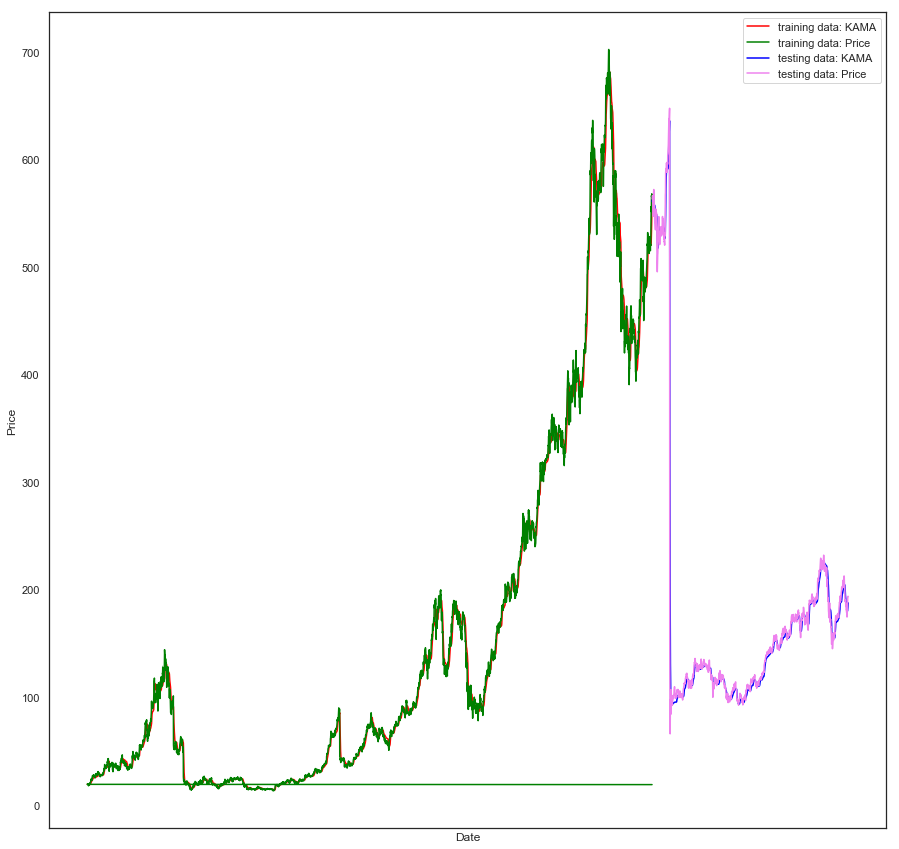

In [13]:
test_data['Price'] = pred['Price']

plt.figure(figsize=(15,15))
sbn.lineplot(x='Date', y='KAMA', data=train_data.loc[train_data['Company ']=='ABC'], label='training data: KAMA', color='red', sort=False)
sbn.lineplot(x='Date', y='Price', data=train_data.loc[train_data['Company ']=='ABC'], label='training data: Price', color='green', sort=False)
sbn.lineplot(x='Date', y='KAMA', data=test_data.loc[test_data['Company ']=='ABC'], label='testing data: KAMA', color='blue', sort=False)
sbn.lineplot(x='Date', y='Price', data=test_data.loc[test_data['Company ']=='ABC'], label='testing data: Price', color='violet', sort=False)
plt.legend()
plt.xticks([],[])
plt.show()

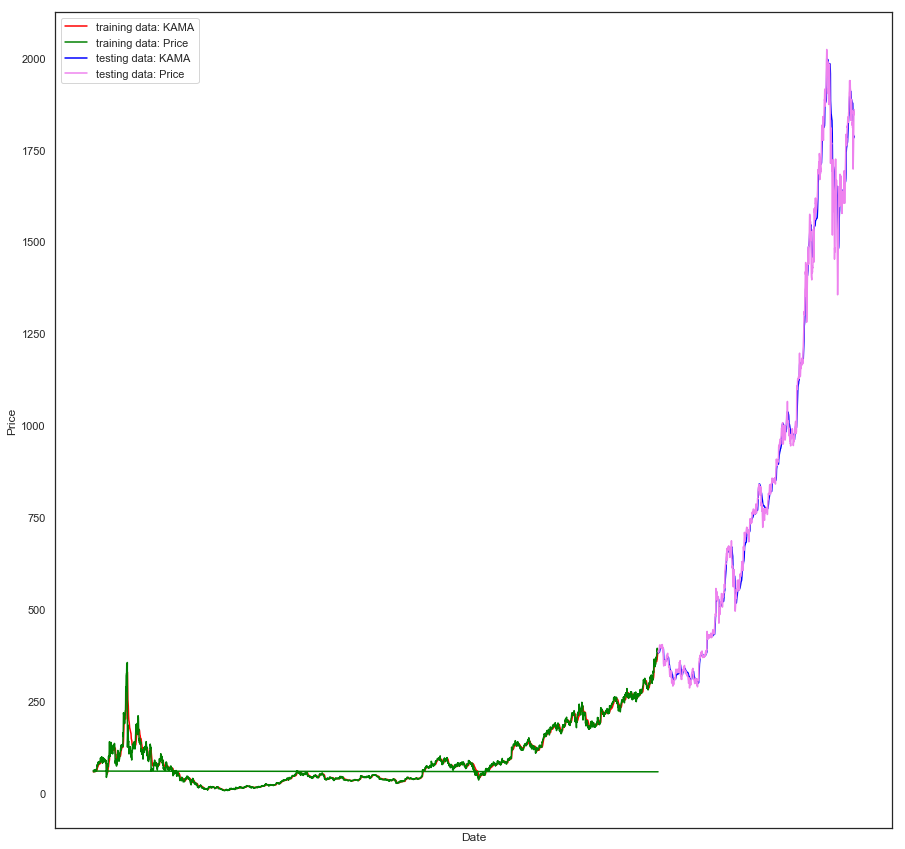

In [14]:
test_data['Price'] = pred['Price']

plt.figure(figsize=(15,15))
sbn.lineplot(x='Date', y='KAMA', data=train_data.loc[train_data['Company ']=='DEF'], label='training data: KAMA', color='red', sort=False)
sbn.lineplot(x='Date', y='Price', data=train_data.loc[train_data['Company ']=='DEF'], label='training data: Price', color='green', sort=False)
sbn.lineplot(x='Date', y='KAMA', data=test_data.loc[test_data['Company ']=='DEF'], label='testing data: KAMA', color='blue', sort=False)
sbn.lineplot(x='Date', y='Price', data=test_data.loc[test_data['Company ']=='DEF'], label='testing data: Price', color='violet', sort=False)
plt.legend()
plt.xticks([],[])
plt.show()

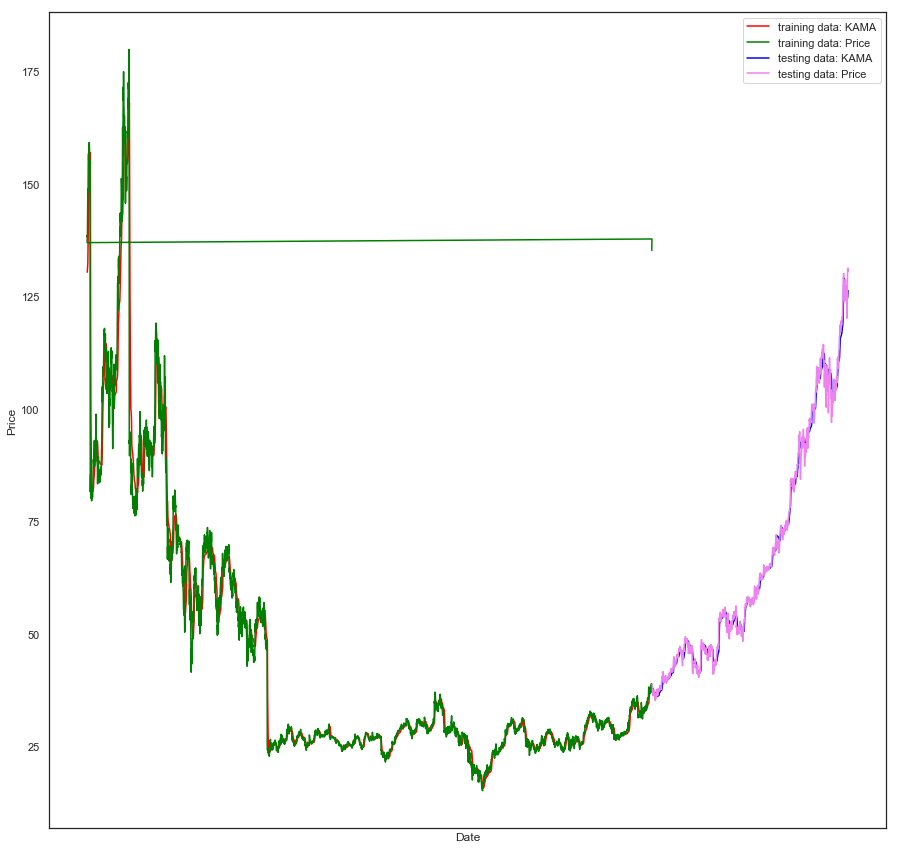

In [15]:
test_data['Price'] = pred['Price']

plt.figure(figsize=(15,15))
sbn.lineplot(x='Date', y='KAMA', data=train_data.loc[train_data['Company ']=='GHI'], label='training data: KAMA', color='red', sort=False)
sbn.lineplot(x='Date', y='Price', data=train_data.loc[train_data['Company ']=='GHI'], label='training data: Price', color='green', sort=False)
sbn.lineplot(x='Date', y='KAMA', data=test_data.loc[test_data['Company ']=='GHI'], label='testing data: KAMA', color='blue', sort=False)
sbn.lineplot(x='Date', y='Price', data=test_data.loc[test_data['Company ']=='GHI'], label='testing data: Price', color='violet', sort=False)
plt.legend()
plt.xticks([],[])
plt.show()